# Clasificación de animales con CNN

In [86]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from keras.preprocessing.image import ImageDataGenerator

# Red neuronal convolucional
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Checkpoints
from keras.callbacks import ModelCheckpoint

In [75]:
# Algunos parámetros generales
IMG_WIDTH, IMG_HEIGHT = 200, 200
BATCH_SIZE = 64
IMG_PATH = 'animals'

## Preprocesamiento de las imágenes

Vamos a utilizar la clase `ImageDataGenerator` para generar el conjunto de datos de entrenamiento y pruebas, a partir de las imágenes en el directorio `IMG_PATH`

In [76]:
# Obtenemos una instancia del ImageDataGenerator 
# para realizar Data Augmentation
# 20% para datos de validación
dataGenerator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=5,
    horizontal_flip=True,
    validation_split=0.2
)

In [80]:
# Obtener un generador de imágenes aumentadas para entrenamiento
trainGenerator = datagen.flow_from_directory(IMG_PATH, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    #save_to_dir='training',
    subset='training'
)

# Obtener un generador de imágenes aumentadas para validación
validationGenerator = dataGenerator.flow_from_directory(IMG_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, 
    save_to_dir='validation',
    class_mode='categorical',
    subset='validation'
)

Found 171 images belonging to 5 classes.
Found 41 images belonging to 5 classes.


In [207]:
# Obtenemos un batch del generador de imágenes
x_batch, y_batch = validationGenerator.next()

In [208]:
print("Shape del batch X: ", x_batch.shape)
print("Shape de los labels Y: ", y_batch.shape)

Shape del batch X:  (41, 200, 200, 3)
Shape de los labels Y:  (41, 5)


## Definición del modelo

In [99]:
# Definición de la CNN
model = Sequential()
# Capa de convolución de 32 canales de salida con kernel 3x3,
# Activación ReLU
# Capa de pooling para bajar la dimensionalidad de la imagen
# Las capas anteriores generan una gran cantidad de valores de pixeles, es
# típicamente más fácil para la red neuronal aprender las características de la
# imagen si el tamaño se reduce progresivamente.
# También ayudan a reducir el número de parámetros requeridos
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Capa de convolución con 64 canales de salida
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Capa de Dropout, para apagar aleatoriamente algunas de las unidades de entrada
# durante el entrenamiento, para ayudar a prevenir el overfitting
model.add(Dropout(rate=0.25))
# Capa de Flatten, para aplanar la salida bidimensional hacia una capa densa
model.add(Flatten())
# Capa densa con 128 neuronas de salida con dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
# Capa de salida con activación softmax
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 28224)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)             

In [181]:
# Compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Crear un checkpoint cuando haya mejoras
checkpoint_file = "model-weights-cnn.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [90]:
# Entrenamiento del modelo
model.fit_generator(
    generator=trainGenerator,
    steps_per_epoch= (trainGenerator.samples // BATCH_SIZE),
    validation_data=validationGenerator,
    validation_steps= (validationGenerator.samples // BATCH_SIZE), 
    epochs=100,
    callbacks=[checkpoint],
    use_multiprocessing=True)

Epoch 1/100
2/2 [==============================] - 8s 4s/step - loss: 2.3093 - acc: 0.2162 - val_loss: 4.4521 - val_acc: 0.1951

Epoch 00001: val_acc improved from -inf to 0.19512, saving model to model-weights-cnn.best.hdf5
Epoch 2/100
2/2 [==============================] - 6s 3s/step - loss: 4.1854 - acc: 0.2245 - val_loss: 1.9698 - val_acc: 0.1951

Epoch 00002: val_acc did not improve from 0.19512
Epoch 3/100
2/2 [==============================] - 8s 4s/step - loss: 2.2053 - acc: 0.1797 - val_loss: 1.7140 - val_acc: 0.2683

Epoch 00003: val_acc improved from 0.19512 to 0.26829, saving model to model-weights-cnn.best.hdf5
Epoch 4/100
2/2 [==============================] - 7s 3s/step - loss: 1.7055 - acc: 0.2891 - val_loss: 1.6586 - val_acc: 0.2195

Epoch 00004: val_acc did not improve from 0.26829
Epoch 5/100
2/2 [==============================] - 6s 3s/step - loss: 1.6664 - acc: 0.2558 - val_loss: 1.6195 - val_acc: 0.1951

Epoch 00005: val_acc did not improve from 0.26829
Epoch 6/10


Epoch 00043: val_acc did not improve from 0.78049
Epoch 44/100
2/2 [==============================] - 8s 4s/step - loss: 0.3455 - acc: 0.8906 - val_loss: 0.7159 - val_acc: 0.7561

Epoch 00044: val_acc did not improve from 0.78049
Epoch 45/100
2/2 [==============================] - 7s 3s/step - loss: 0.2319 - acc: 0.9309 - val_loss: 0.7471 - val_acc: 0.6341

Epoch 00045: val_acc did not improve from 0.78049
Epoch 46/100
2/2 [==============================] - 7s 4s/step - loss: 0.2911 - acc: 0.8828 - val_loss: 0.7396 - val_acc: 0.7073

Epoch 00046: val_acc did not improve from 0.78049
Epoch 47/100
2/2 [==============================] - 6s 3s/step - loss: 0.2082 - acc: 0.9302 - val_loss: 0.7336 - val_acc: 0.7073

Epoch 00047: val_acc did not improve from 0.78049
Epoch 48/100
2/2 [==============================] - 7s 4s/step - loss: 0.3119 - acc: 0.8984 - val_loss: 0.8017 - val_acc: 0.7561

Epoch 00048: val_acc did not improve from 0.78049
Epoch 49/100
2/2 [==============================]


Epoch 00088: val_acc did not improve from 0.85366
Epoch 89/100
2/2 [==============================] - 6s 3s/step - loss: 0.0922 - acc: 0.9767 - val_loss: 0.8497 - val_acc: 0.8049

Epoch 00089: val_acc did not improve from 0.85366
Epoch 90/100
2/2 [==============================] - 7s 4s/step - loss: 0.0888 - acc: 0.9688 - val_loss: 0.7951 - val_acc: 0.8293

Epoch 00090: val_acc did not improve from 0.85366
Epoch 91/100
2/2 [==============================] - 6s 3s/step - loss: 0.1377 - acc: 0.9508 - val_loss: 0.6826 - val_acc: 0.8537

Epoch 00091: val_acc did not improve from 0.85366
Epoch 92/100
2/2 [==============================] - 8s 4s/step - loss: 0.0796 - acc: 0.9766 - val_loss: 0.8684 - val_acc: 0.7805

Epoch 00092: val_acc did not improve from 0.85366
Epoch 93/100
2/2 [==============================] - 7s 3s/step - loss: 0.0963 - acc: 0.9674 - val_loss: 0.7684 - val_acc: 0.8293

Epoch 00093: val_acc did not improve from 0.85366
Epoch 94/100
2/2 [==============================]

In [209]:
model.predict_classes(x_batch)

array([4, 0, 4, 4, 4, 1, 4, 0, 4, 1, 2, 2, 1, 4, 1, 0, 2, 0, 3, 4, 2, 4,
       0, 4, 4, 4, 3, 2, 3, 0, 0, 1, 2, 1, 0, 4, 0, 3, 1, 1, 3])

In [210]:
model.evaluate_generator(generator=trainGenerator)

[0.075994651612134, 0.9883040935672515]

### Cargar modelo

In [176]:
model.load_weights("model-weights-cnn.best.hdf5")


In [184]:
model.predict_classes(x_batch)

array([4, 0, 0, 1, 0, 4, 4, 3, 1, 3, 2, 0, 0, 0, 4, 2, 2, 1, 2, 4, 4, 0,
       0, 4, 4, 3, 1, 4, 3, 4, 1, 4, 3, 1, 1, 2, 0, 3, 1, 0, 1])

In [211]:
labels = np.argmax(y_batch, axis=1)
labels

array([0, 0, 4, 4, 0, 1, 3, 0, 4, 1, 2, 2, 1, 0, 1, 0, 2, 4, 3, 4, 2, 1,
       0, 4, 3, 4, 3, 2, 3, 4, 2, 1, 2, 1, 2, 4, 0, 3, 1, 1, 3])

In [178]:
trainGenerator.class_indices

{'ant': 0, 'beaver': 1, 'lobster': 2, 'panda': 3, 'pigeon': 4}

In [104]:
trainGenerator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [111]:
inv_class_dict = {v: k for k, v in trainGenerator.class_indices.items()}
inv_class_dict

{0: 'ant', 1: 'beaver', 2: 'lobster', 3: 'panda', 4: 'pigeon'}

## Graficar algunas predicciones

In [141]:
model.predict_classes(x_batch[0].reshape(1, 200, 200, 3))

array([4])

In [114]:
x_batch[0].shape

(200, 200, 3)

In [117]:
y_batch[0]

array([0., 0., 0., 0., 1.], dtype=float32)

Text(0.5, 1.0, 'pigeon')

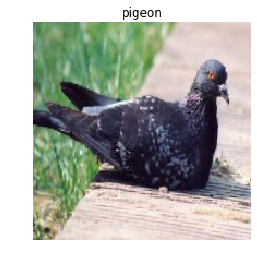

In [119]:
plt.imshow(x_batch[0])
plt.axis('off')
plt.title('pigeon')

In [125]:
np.argmax(y_batch,axis=1)

array([4, 0, 0, 2, 4, 4, 4, 3, 1, 3, 2, 0, 2, 0, 0, 2, 2, 1, 2, 4, 3, 2,
       0, 0, 4, 3, 1, 4, 3, 4, 1, 4, 3, 1, 1, 2, 1, 3, 1, 0, 1])

In [135]:
np.argmax(y_batch[0])

4

In [132]:
"hola %s, %0.2f" % ("rodrigo", 2.5)  

'hola rodrigo, 2.50'

In [191]:
def predictElement(x, label, model, inv_dict):
    # Obtener la predicción del elemento
    predicted_label = model.predict_classes(x.reshape(1, IMG_WIDTH, IMG_HEIGHT, -1))[0]
    
    # Obtener las etiquetas
    predicted_class = inv_dict[predicted_label]
    actual_class = inv_dict[label]
    
    # Graficar la imagen
    plt.imshow(x)
    plt.axis('off')
    plt.title("Clase: %s, Modelo: %s" % (actual_class, predicted_class))

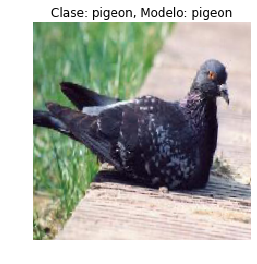

In [195]:
predictElement(x_batch[0], 4, model, inv_class_dict)

In [149]:
np.random.randint(0, 42, 10)

array([ 1, 29, 31, 23, 29,  4,  3, 17, 33,  8])

In [152]:
x_batch[np.array([0,1,4])].shape

(3, 200, 200, 3)

In [163]:
np.ceil(16/5).astype(np.int)

4

In [244]:
def graficarElementos(X, labels, n, model, inv_dict, columns=5):
    # Obtener la muestra de ejemplos
    N = X.shape[0]
    rnd_idx = np.random.randint(0, N, n)
    x_batch = X[rnd_idx]
    labels_batch = labels[rnd_idx]
    
    # Graficar los elementos
    rows = np.ceil(n / columns).astype(np.int)
    plt.figure(figsize = (16,10))
    for i in range(n):
        plt.subplot(rows, columns, i+1)
        predictElement(x_batch[i], labels_batch[i], model, inv_dict)
        

In [245]:
inv_class_dict

{0: 'ant', 1: 'beaver', 2: 'lobster', 3: 'panda', 4: 'pigeon'}

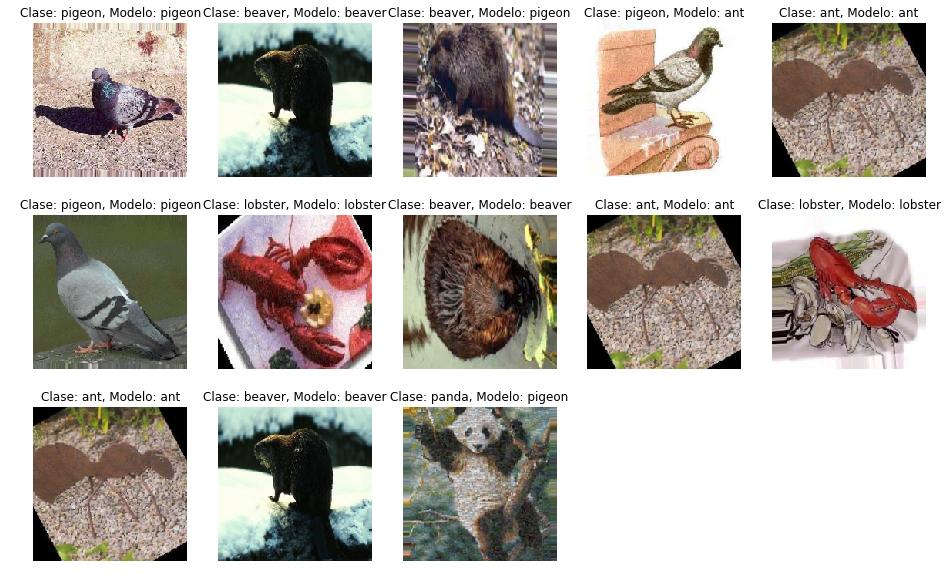

In [246]:
labels = np.argmax(y_batch, axis=1)
graficarElementos(x_batch, np.argmax(y_batch, axis=1), 13, model, inv_class_dict)

In [173]:
y_batch

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.